<a href="https://colab.research.google.com/github/mistiqve/lc_risk_analysis/blob/master/ml_project_yj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from collections import Counter


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pd.set_option('display.max_rows', 200)
data_path = "/content/drive/My Drive/loan.csv"

## Load & Preprocess Data

In [52]:
# LOAD ALL DATA

loan_df = pd.read_csv(data_path)
print(loan_df.shape)
loan_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260668, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,Feb-2006,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,Dec-2000,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Values

In [53]:
def get_percent_null_val(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
    return missing_value_df

missing_value_df = get_percent_null_val(loan_df)
missing_value_df

,column_name,percent_missing
id,id,100.000000
url,url,100.000000
member_id,member_id,100.000000
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.627278
hardship_length,hardship_length,99.530537
hardship_reason,hardship_reason,99.530537
hardship_status,hardship_status,99.530537
deferral_term,deferral_term,99.530537
hardship_amount,hardship_amount,99.530537
hardship_start_date,hardship_start_date,99.530537


In [54]:
col_to_remove = missing_value_df.loc[missing_value_df.percent_missing>80].column_name.tolist()
print(len(col_to_remove))
df = loan_df.drop(col_to_remove, axis=1).dropna()
print(df.shape)
df.head()

39
(75170, 106)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
8,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Legal Assistant III,10+ years,MORTGAGE,53580.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,327xx,FL,21.16,0.0,Aug-1998,1.0,32.0,8.0,0.0,8018,35.2,38.0,w,4786.79,4786.79,353.89,353.89,213.21,140.68,0.0,0.0,0.0,...,12.0,5235.0,13786.0,35.9,0.0,0.0,145.0,244.0,6.0,3.0,3.0,6.0,33.0,2.0,32.0,2.0,4.0,5.0,5.0,10.0,20.0,6.0,15.0,5.0,8.0,0.0,0.0,0.0,6.0,78.9,60.0,0.0,0.0,57426.0,41882.0,21500.0,34626.0,N,Cash,N
18,16000,16000,16000.0,60 months,20.89,431.87,D,D4,Neonatal Nurse Practitioner,4 years,MORTGAGE,120000.0,Not Verified,Dec-2018,Current,n,credit_card,Credit card refinancing,720xx,AR,27.57,1.0,Jul-2005,0.0,8.0,13.0,0.0,18826,82.2,37.0,w,15690.66,15690.66,835.89,835.89,309.34,526.55,0.0,0.0,0.0,...,5.0,33403.0,430.0,96.8,0.0,0.0,136.0,146.0,12.0,4.0,2.0,12.0,48.0,4.0,8.0,2.0,2.0,4.0,2.0,5.0,24.0,6.0,10.0,4.0,13.0,0.0,0.0,0.0,2.0,86.5,100.0,0.0,0.0,444217.0,266754.0,13500.0,239338.0,N,Cash,N
23,3500,3500,3500.0,36 months,20.89,131.67,D,D4,gas attendant,10+ years,MORTGAGE,40000.0,Source Verified,Dec-2018,Current,n,car,Car financing,078xx,NJ,9.09,0.0,Oct-2004,1.0,24.0,4.0,0.0,1944,33.5,18.0,w,3357.29,3357.29,257.25,257.25,142.71,114.54,0.0,0.0,0.0,...,3.0,47449.0,3683.0,26.3,0.0,0.0,150.0,170.0,1.0,1.0,4.0,8.0,48.0,1.0,48.0,2.0,1.0,2.0,1.0,8.0,3.0,2.0,11.0,2.0,4.0,0.0,0.0,0.0,3.0,38.9,0.0,0.0,0.0,217000.0,26902.0,5000.0,25000.0,N,Cash,N
31,10000,10000,10000.0,60 months,19.92,264.50,D,D3,Material Handler,10+ years,MORTGAGE,80000.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,648xx,MO,20.67,0.0,Apr-2005,0.0,37.0,11.0,0.0,13198,73.7,19.0,w,9801.36,9801.36,512.40,512.40,198.64,313.76,0.0,0.0,0.0,...,2.0,10011.0,779.0,90.3,0.0,0.0,148.0,164.0,11.0,11.0,1.0,149.0,37.0,11.0,37.0,0.0,2.0,8.0,2.0,4.0,6.0,8.0,12.0,8.0,11.0,0.0,0.0,0.0,1.0,84.2,50.0,0.0,0.0,170230.0,37606.0,8000.0,55030.0,N,Cash,N
32,16000,16000,16000.0,60 months,17.97,406.04,D,D1,Instructional Coordinator,5 years,MORTGAGE,51000.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,284xx,NC,21.91,0.0,Oct-2005,1.0,52.0,11.0,0.0,7326,24.8,27.0,w,15664.63,15664.63,788.12,788.12,335.37,452.75,0.0,0.0,0.0,...,3.0,3576.0,22174.0,24.8,0.0,0.0,123.0,158.0,6.0,2.0,0.0,6.0,52.0,4.0,52.0,6.0,2.0,2.0,3.0,6.0,21.0,3.0,6.0,2.0,11.0,0.0,0.0,0.0,3.0,77.8,0.0,0.0,0.0,67924.0,39339.0,29500.0,38424.0,N,Cash,N


### Feature Selection

In [55]:
loan_df['emp_length'].value_counts()

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: emp_length, dtype: int64

In [56]:
loan_df['grade'].value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [57]:
# df = loan_df[['home_ownership','annual_inc','delinq_2yrs','emp_length','grade','loan_status','mort_acc',
#               'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mths_since_last_delinq','inq_fi','open_acc',
#               'pub_rec','pub_rec_bankruptcies','revol_util','sub_grade','total_acc','int_rate',
#               'total_rev_hi_lim', 'total_bal_il','tot_cur_bal','dti', 'total_bc_limit',
#               'total_cu_tl','pct_tl_nvr_dlq','percent_bc_gt_75', 'term']].dropna()
df = loan_df[['home_ownership','annual_inc','delinq_2yrs','emp_length','grade','loan_status','mort_acc', 'mo_sin_old_rev_tl_op', 'mths_since_last_delinq','inq_fi','open_acc',
              'pub_rec','pub_rec_bankruptcies', 'term','loan_amnt','int_rate','last_pymnt_amnt','total_bc_limit','verification_status','purpose']].dropna()

df['total_bc_limit'] = np.log(1+df['total_bc_limit'])
df['last_pymnt_amnt'] = np.log(1+df['last_pymnt_amnt'])
df['int_rate'] = np.log(1+df['int_rate']/100)
df['annual_inc'] = np.log(1+df['annual_inc'])
df['loan_amnt'] = np.log(1+df['loan_amnt'])
print(df.shape)
df.head()

(633572, 20)


,home_ownership,annual_inc,delinq_2yrs,emp_length,grade,loan_status,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,term,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit,verification_status,purpose
1,MORTGAGE,11.407576,0.0,10+ years,D,Current,3.0,378.0,71.0,2.0,13.0,1.0,1.0,60 months,10.308986,0.173449,6.657022,9.615872,Source Verified,debt_consolidation
8,MORTGAGE,10.888950,0.0,10+ years,D,Current,3.0,244.0,32.0,2.0,8.0,0.0,0.0,36 months,8.517393,0.165260,5.202302,9.975855,Source Verified,debt_consolidation
9,OWN,12.611541,1.0,< 1 year,C,Current,1.0,200.0,17.0,2.0,38.0,0.0,0.0,36 months,8.699681,0.135143,5.334842,11.495789,Not Verified,debt_consolidation
10,MORTGAGE,10.819798,1.0,< 1 year,D,Current,3.0,105.0,22.0,2.0,6.0,0.0,0.0,36 months,8.612685,0.201716,5.356822,8.476580,Not Verified,credit_card
13,MORTGAGE,11.944714,2.0,4 years,D,Current,0.0,74.0,6.0,3.0,27.0,0.0,0.0,36 months,8.779711,0.165260,5.463408,9.417436,Source Verified,debt_consolidation


### Data Preprocessing 

In [58]:
df0 = df.drop(['loan_status','grade','home_ownership','term','verification_status','purpose'], axis=1)
print(type(df0), df0.shape)
df0.head()

<class 'pandas.core.frame.DataFrame'> (633572, 14)


,annual_inc,delinq_2yrs,emp_length,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit
1,11.407576,0.0,10+ years,3.0,378.0,71.0,2.0,13.0,1.0,1.0,10.308986,0.173449,6.657022,9.615872
8,10.888950,0.0,10+ years,3.0,244.0,32.0,2.0,8.0,0.0,0.0,8.517393,0.165260,5.202302,9.975855
9,12.611541,1.0,< 1 year,1.0,200.0,17.0,2.0,38.0,0.0,0.0,8.699681,0.135143,5.334842,11.495789
10,10.819798,1.0,< 1 year,3.0,105.0,22.0,2.0,6.0,0.0,0.0,8.612685,0.201716,5.356822,8.476580
13,11.944714,2.0,4 years,0.0,74.0,6.0,3.0,27.0,0.0,0.0,8.779711,0.165260,5.463408,9.417436


In [59]:
#Process emp_length

#RUN ONLY ONCE
# df0.loc[df0.emp_length == "< 1 year", 'emp_length'] = 0
# df0.loc[df0.emp_length == "1 year", 'emp_length'] = 1
# df0.loc[df0.emp_length == "2 years", 'emp_length'] = 2
# df0.loc[df0.emp_length == "3 years", 'emp_length'] = 3
# df0.loc[df0.emp_length == "4 years", 'emp_length'] = 4
# df0.loc[df0.emp_length == "5 years", 'emp_length'] = 5
# df0.loc[df0.emp_length == "6 years", 'emp_length'] = 6
# df0.loc[df0.emp_length == "7 years", 'emp_length'] = 7
# df0.loc[df0.emp_length == "8 years", 'emp_length'] = 8
# df0.loc[df0.emp_length == "9 years", 'emp_length'] = 9
# df0.loc[df0.emp_length == "10+ years", 'emp_length'] = 10

df0.loc[df0.emp_length == "< 1 year", 'emp_length'] = 0
df0.loc[df0.emp_length == "1 year", 'emp_length'] = 0
df0.loc[df0.emp_length == "2 years", 'emp_length'] = 0
df0.loc[df0.emp_length == "3 years", 'emp_length'] = 0
df0.loc[df0.emp_length == "4 years", 'emp_length'] = 1
df0.loc[df0.emp_length == "5 years", 'emp_length'] = 1
df0.loc[df0.emp_length == "6 years", 'emp_length'] = 1
df0.loc[df0.emp_length == "7 years", 'emp_length'] = 2
df0.loc[df0.emp_length == "8 years", 'emp_length'] = 2
df0.loc[df0.emp_length == "9 years", 'emp_length'] = 2
df0.loc[df0.emp_length == "10+ years", 'emp_length'] = 3



df0['emp_length'].value_counts()
df0.drop(['emp_length'],axis = 1)

,annual_inc,delinq_2yrs,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit
1,11.407576,0.0,3.0,378.0,71.0,2.0,13.0,1.0,1.0,10.308986,0.173449,6.657022,9.615872
8,10.888950,0.0,3.0,244.0,32.0,2.0,8.0,0.0,0.0,8.517393,0.165260,5.202302,9.975855
9,12.611541,1.0,1.0,200.0,17.0,2.0,38.0,0.0,0.0,8.699681,0.135143,5.334842,11.495789
10,10.819798,1.0,3.0,105.0,22.0,2.0,6.0,0.0,0.0,8.612685,0.201716,5.356822,8.476580
13,11.944714,2.0,0.0,74.0,6.0,3.0,27.0,0.0,0.0,8.779711,0.165260,5.463408,9.417436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260654,11.289794,0.0,0.0,171.0,46.0,0.0,21.0,0.0,0.0,10.308986,0.157773,6.617443,10.805700
2260655,11.251574,0.0,1.0,52.0,38.0,0.0,9.0,0.0,0.0,9.798183,0.267352,6.429800,9.532496
2260658,11.350418,0.0,1.0,198.0,36.0,1.0,19.0,0.0,0.0,9.615872,0.148592,9.589782,10.038936
2260660,11.082158,0.0,0.0,163.0,29.0,0.0,5.0,0.0,0.0,9.210440,0.118849,5.817468,9.495594


In [60]:
df0['term'] = df['term'].factorize()[0]
df0.head()


,annual_inc,delinq_2yrs,emp_length,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit,term
1,11.407576,0.0,3,3.0,378.0,71.0,2.0,13.0,1.0,1.0,10.308986,0.173449,6.657022,9.615872,0
8,10.888950,0.0,3,3.0,244.0,32.0,2.0,8.0,0.0,0.0,8.517393,0.165260,5.202302,9.975855,1
9,12.611541,1.0,0,1.0,200.0,17.0,2.0,38.0,0.0,0.0,8.699681,0.135143,5.334842,11.495789,1
10,10.819798,1.0,0,3.0,105.0,22.0,2.0,6.0,0.0,0.0,8.612685,0.201716,5.356822,8.476580,1
13,11.944714,2.0,1,0.0,74.0,6.0,3.0,27.0,0.0,0.0,8.779711,0.165260,5.463408,9.417436,1


In [61]:
# One hot encoder home_ownership, and grade
df0['home_ownership'] = df['home_ownership']
df0 = pd.get_dummies(df0, columns=['home_ownership'], prefix = ['home'])
df0['grade']=df['grade']
df0 = pd.get_dummies(df0, columns = ['grade'], prefix=['grade'])
df0['verification_status'] = df['verification_status']
df0 = pd.get_dummies(df0, columns = ['verification_status'], prefix=['verification_status'] )
df0['purpose'] = df['purpose']
df0 = pd.get_dummies(df0, columns = ['purpose'], prefix=['purpose'] )

df0.head()

,annual_inc,delinq_2yrs,emp_length,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit,term,home_ANY,home_MORTGAGE,home_NONE,home_OWN,home_RENT,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
1,11.407576,0.0,3,3.0,378.0,71.0,2.0,13.0,1.0,1.0,10.308986,0.173449,6.657022,9.615872,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,10.888950,0.0,3,3.0,244.0,32.0,2.0,8.0,0.0,0.0,8.517393,0.165260,5.202302,9.975855,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,12.611541,1.0,0,1.0,200.0,17.0,2.0,38.0,0.0,0.0,8.699681,0.135143,5.334842,11.495789,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,10.819798,1.0,0,3.0,105.0,22.0,2.0,6.0,0.0,0.0,8.612685,0.201716,5.356822,8.476580,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13,11.944714,2.0,1,0.0,74.0,6.0,3.0,27.0,0.0,0.0,8.779711,0.165260,5.463408,9.417436,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [62]:
df0.columns

Index(['annual_inc', 'delinq_2yrs', 'emp_length', 'mort_acc',
       'mo_sin_old_rev_tl_op', 'mths_since_last_delinq', 'inq_fi', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'loan_amnt', 'int_rate',
       'last_pymnt_amnt', 'total_bc_limit', 'term', 'home_ANY',
       'home_MORTGAGE', 'home_NONE', 'home_OWN', 'home_RENT', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [63]:
df0 = df0.drop(['home_ANY', 'grade_D','verification_status_Verified','purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding','purpose_car'], axis=1)
df0.columns

Index(['annual_inc', 'delinq_2yrs', 'emp_length', 'mort_acc',
       'mo_sin_old_rev_tl_op', 'mths_since_last_delinq', 'inq_fi', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'loan_amnt', 'int_rate',
       'last_pymnt_amnt', 'total_bc_limit', 'term', 'home_MORTGAGE',
       'home_NONE', 'home_OWN', 'home_RENT', 'grade_A', 'grade_B', 'grade_C',
       'grade_E', 'grade_F', 'grade_G', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation'],
      dtype='object')

In [64]:
# Scaling By Features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df0[df0.columns] = scaler.fit_transform(df0[df0.columns])
df0.head()

,annual_inc,delinq_2yrs,emp_length,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit,term,home_MORTGAGE,home_NONE,home_OWN,home_RENT,grade_A,grade_B,grade_C,grade_E,grade_F,grade_G,verification_status_Not Verified,verification_status_Source Verified,purpose_credit_card,purpose_debt_consolidation
1,0.376078,-0.531504,1.126292,0.744323,2.039614,1.662099,0.538788,0.155372,1.376838,2.710089,1.253909,1.122246,0.010534,0.124655,-1.616420,0.956236,-0.001256,-0.359269,-0.754422,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565
8,-0.582827,-0.531504,1.126292,0.744323,0.601814,-0.121667,0.538788,-0.702998,-0.316069,-0.301405,-1.229244,0.933645,-0.915928,0.368661,0.618651,0.956236,-0.001256,-0.359269,-0.754422,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565
9,2.602128,0.323876,-1.187734,-0.347261,0.129701,-0.807731,0.538788,4.447225,-0.316069,-0.301405,-0.976591,0.239994,-0.831517,1.398914,0.618651,-1.045767,-0.001256,2.783431,-0.754422,-0.440119,-0.659985,1.466192,-0.23123,-0.122712,-0.071628,1.416969,-0.868951,-0.508454,0.887565
10,-0.710683,0.323876,-1.187734,0.744323,-0.889635,-0.579043,0.538788,-1.046347,-0.316069,-0.301405,-1.097169,1.773267,-0.817519,-0.647588,0.618651,0.956236,-0.001256,-0.359269,-0.754422,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,1.416969,-0.868951,1.966746,-1.126678
13,1.369211,1.179256,-0.416392,-0.893053,-1.222261,-1.310845,1.162132,2.558810,-0.316069,-0.301405,-0.865670,0.933645,-0.749638,-0.009850,0.618651,0.956236,-0.001256,-0.359269,-0.754422,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565


In [65]:
df0['loan_status'] = df['loan_status']
df0['loan_status'].value_counts()

Current               379034
Fully Paid            184277
Charged Off            54713
Late (31-120 days)      9771
In Grace Period         4148
Late (16-30 days)       1609
Default                   20
Name: loan_status, dtype: int64

In [0]:
df0.loc[df0.loan_status == "Current", 'loan_status'] = 1
df0.loc[df0.loan_status == "Fully Paid", 'loan_status'] = 1
df0.loc[df0.loan_status == "In Grace Period", 'loan_status'] = 0
df0.loc[df0.loan_status == "Late (31-120 days)", 'loan_status'] = 0
df0.loc[df0.loan_status == "Late (16-30 days)", 'loan_status'] = 0
df0.loc[df0.loan_status == "Default", 'loan_status'] = 0
df0.loc[df0.loan_status == "Charged Off", 'loan_status'] = 0

In [67]:
df0['loan_status'].value_counts()

1    563311
0     70261
Name: loan_status, dtype: int64

In [68]:
df_good = df0[df0['loan_status']==1].sample(n=70000)
df_bad = df0[df0['loan_status']==0]
df_downsampled = pd.concat([df_good,df_bad])
df_downsampled.head()

,annual_inc,delinq_2yrs,emp_length,mort_acc,mo_sin_old_rev_tl_op,mths_since_last_delinq,inq_fi,open_acc,pub_rec,pub_rec_bankruptcies,loan_amnt,int_rate,last_pymnt_amnt,total_bc_limit,term,home_MORTGAGE,home_NONE,home_OWN,home_RENT,grade_A,grade_B,grade_C,grade_E,grade_F,grade_G,verification_status_Not Verified,verification_status_Source Verified,purpose_credit_card,purpose_debt_consolidation,loan_status
122633,0.907978,-0.531504,1.126292,-0.893053,0.151160,1.433411,-0.707899,0.327046,-0.316069,-0.301405,-2.498809,0.933645,-1.494211,0.180989,0.618651,-1.045767,-0.001256,-0.359269,1.325518,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,-0.868951,-0.508454,-1.126678,1
121435,-0.710683,-0.531504,0.354950,-0.347261,0.333568,-0.258880,-0.707899,-0.359650,-0.316069,-0.301405,-0.493905,-0.579207,-0.646984,1.098435,0.618651,0.956236,-0.001256,-0.359269,-0.754422,-0.440119,1.515185,-0.682039,-0.23123,-0.122712,-0.071628,1.416969,-0.868951,-0.508454,0.887565,1
787725,-1.370135,-0.531504,-0.416392,-0.893053,-0.889635,-0.441831,1.785476,-0.874673,-0.316069,-0.301405,-1.041607,-0.371659,1.010996,-0.771142,0.618651,-1.045767,-0.001256,-0.359269,1.325518,-0.440119,1.515185,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,-0.868951,1.966746,-1.126678,1
846594,-0.088579,-0.531504,-1.187734,-0.893053,-0.396062,-0.304618,-0.707899,0.327046,-0.316069,-0.301405,-0.953686,-0.388195,1.322613,-0.411538,0.618651,-1.045767,-0.001256,-0.359269,1.325518,-0.440119,1.515185,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565,1
220246,-0.373589,-0.531504,-1.187734,-0.347261,-0.084896,1.662099,-0.707899,1.357091,-0.316069,-0.301405,1.001220,0.239994,-0.167089,0.884192,-1.616420,-1.045767,-0.001256,-0.359269,1.325518,-0.440119,-0.659985,1.466192,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565,1


In [69]:
corr = df0.corr()['loan_status'].sort_values()
corr

int_rate                              -0.182805
grade_E                               -0.095335
grade_F                               -0.089298
grade_G                               -0.064354
loan_amnt                             -0.048563
home_RENT                             -0.046947
inq_fi                                -0.045514
pub_rec                               -0.039681
purpose_debt_consolidation            -0.031600
pub_rec_bankruptcies                  -0.031273
grade_C                               -0.025418
delinq_2yrs                           -0.023601
open_acc                              -0.018512
verification_status_Source Verified   -0.012528
home_OWN                              -0.002336
home_NONE                              0.000444
emp_length                             0.017222
mths_since_last_delinq                 0.024353
annual_inc                             0.035456
total_bc_limit                         0.037875
purpose_credit_card                    0

In [70]:
X = df_downsampled.drop(['loan_status'], axis=1).to_numpy()
y = df_downsampled['loan_status'].to_numpy()
print(X.shape, y.shape)
print(type(X), type(y))

(140261, 29) (140261,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Split Data

In [71]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            random_state=42, 
                                                            stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                test_size=0.2, 
                                                random_state=42, 
                                                stratify = y_train_val)
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({0: 44966, 1: 44800})
Counter({0: 11242, 1: 11200})
Counter({0: 14053, 1: 14000})


In [72]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(89766, 29) (89766,)
(22442, 29) (22442,)
(28053, 29) (28053,)


## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

clf = LogisticRegression(max_iter=5000, penalty = 'l2')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7003172566213952


In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

10831 3222 5185 8815
              precision    recall  f1-score   support

           0       0.77      0.68      0.72     16016
           1       0.63      0.73      0.68     12037

    accuracy                           0.70     28053
   macro avg       0.70      0.70      0.70     28053
weighted avg       0.71      0.70      0.70     28053



In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

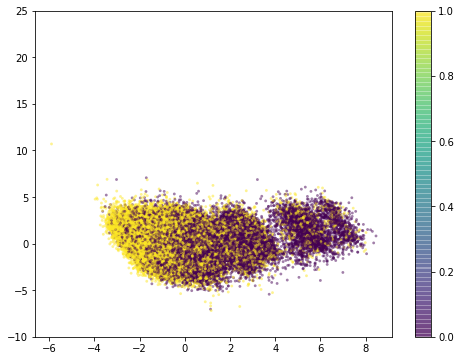

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_train, edgecolor='none', 
            alpha=0.5, s = 8)
#plt.xlim(-10, 30)
plt.ylim(-10, 25)
plt.colorbar()
plt.show()

## Neural Net

In [0]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from matplotlib.pyplot import figure
from torch.utils.data import Dataset, DataLoader

In [78]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

In [0]:
class Dataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        if self.transform is not None:
            item = self.transform(item)
        return (item, self.labels[index])

In [0]:
batch_size = 64

train_data = Dataset(X_train, y_train)
val_data = Dataset(X_test, y_test)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size,
                              shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size,
                              shuffle = True)

In [0]:
class Net(nn.Module):
    def __init__(self, n = 1000):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        x = self.net(x)
        return x

In [0]:
def train_model(model, loss_fn, epochs, train_loader, val_loader, optimizer):

    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []

    model = model.to(device)
    loss_fn = loss_fn.cuda(device)
  
    for epoch in range(epochs):
        correct = 0.0
        cum_loss = 0.0

        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = Variable(inputs.float().to(device))
            labels = Variable(labels.to(device))
            pred = model(inputs)
            loss = loss_fn(pred, labels)

            _, max_labels = pred.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 400 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batch_size)))

        train_accuracies.append(correct / len(train))
        train_losses.append(cum_loss / (i + 1))   

        # Validation.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = Variable(inputs.float().to(device))
            labels = Variable(labels.to(device))

            pred = model(inputs)
            cum_loss += loss_fn(pred, labels).item()

            _, max_labels = pred.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(X_val))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(val)))
        
    return model, train_accuracies, train_losses, val_accuracies, val_losses

In [83]:
num_epochs = 12
learning_rate = 0.0001

model = Net(n = X_train.shape[1])
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)

trained_model, train_acc, train_loss, val_acc, val_loss = train_model(model, criterion, 
                                                num_epochs, train_loader, val_loader, optimizer)

Train-epoch 0. Iteration 00400, Avg-Loss: 0.6760, Accuracy: 0.5680
Train-epoch 0. Iteration 00800, Avg-Loss: 0.6529, Accuracy: 0.6173
Train-epoch 0. Iteration 01200, Avg-Loss: 0.6359, Accuracy: 0.6380


NameError: ignored

In [0]:
plt.figure()
plt.plot(range(num_epochs), train_acc, color = "b")
plt.plot(range(num_epochs), val_acc, color = "r")

In [0]:
plt.figure()
plt.plot(range(num_epochs), train_loss, color = "g")
plt.plot(range(num_epochs), val_loss, color = "y")

##SVM

In [0]:
from sklearn import svm

####RBF kernel

In [0]:
clf = svm.SVC() #rbf kernel
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

####Poly kernel

In [0]:
clf = svm.SVC(kernel = 'poly') #poly kernel
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

####Sigmoid kernel

In [0]:
clf = svm.SVC(kernel = 'sigmoid') #sigmoid kernel
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

##XGBOOST

In [0]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test,y_test)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



Adaboost

In [86]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import time
start_time = time.time()
# record initializing time
Test_Score = []
CV_Score = []
num_estimators= [200,300,400,500,600]
# the candidate hyperparameters needed to be tuned
for n_esti in num_estimators:
  clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=n_esti)
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("--- %s seconds ---" % (time.time() - start_time))
  # print runtime of model fit under each hyperparameter
  print('num_of_estimators',n_esti ,'train accuracy', accuracy_score(clf.predict(X_train), y_train))
  # print training error and the corresponding number of estimators
  Test_Score.append(accuracy_score(y_pred,y_test))
  CV_Score.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))
  # record test score and CV score in order to use for the comparison in the plot
print(Test_Score,CV_Score)

--- 24.21700620651245 seconds ---
num_of_estimators 200 train accuracy 0.7271015752066484
--- 158.60829854011536 seconds ---
num_of_estimators 300 train accuracy 0.732047768642916
--- 353.46797466278076 seconds ---
num_of_estimators 400 train accuracy 0.7372613238865495
--- 623.7628192901611 seconds ---
num_of_estimators 500 train accuracy 0.7422966379252723
--- 970.1999490261078 seconds ---
num_of_estimators 600 train accuracy 0.7464407459394425
[0.7212775817203151, 0.7261968416925106, 0.7324706804976295, 0.7360710084482943, 0.7396000427761736] [0.7236257991009796, 0.7297528281131079, 0.7338523662726064, 0.7390213921177635, 0.7420180765961121]


11482 2571 4734 9266
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     16216
           1       0.66      0.78      0.72     11837

    accuracy                           0.74     28053
   macro avg       0.74      0.75      0.74     28053
weighted avg       0.75      0.74      0.74     28053



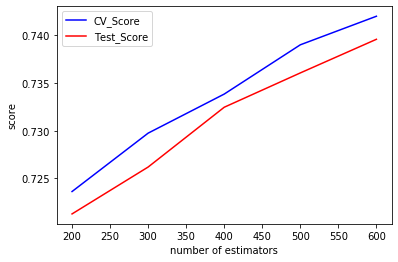

In [87]:
# plot CV accuracy and test accuracy as number of estimators
plt.figure()
plt.plot(num_estimators, CV_Score, color = "b",label='CV_Score')
plt.plot(num_estimators, Test_Score, color = "r",label='Test_Score')
plt.legend()
plt.xlabel('number of estimators')
plt.ylabel('score')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time
hyperparameters ={'max_depth': [3, 5, 10],'n_estimators': [400, 600, 800]}
clf = GridSearchCV(RandomForestClassifier(), hyperparameters)
start_time = time.time()
clf.fit(X_train, y_train)
# print runtime of model fitting
print("--- %s seconds ---" % (time.time() - start_time))
y_pred = clf.predict(X_test)
test_score = accuracy_score(y_pred,y_test)
print('test accuracy',test_score,'best parameter',clf.best_params_,'train accuracy',accuracy_score(clf.predict(X_train), y_train))
# report confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


--- 778.6790254116058 seconds ---
test accuracy 0.7141125726303782 best parameter {'max_depth': 10, 'n_estimators': 400} train accuracy 0.732415391128044
11579 2474 5546 8454
              precision    recall  f1-score   support

           0       0.82      0.68      0.74     17125
           1       0.60      0.77      0.68     10928

    accuracy                           0.71     28053
   macro avg       0.71      0.72      0.71     28053
weighted avg       0.74      0.71      0.72     28053



LOC

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Adaboost
clfada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=600)
clfada = clfada.fit(X_train, y_train)
y_pred_adaboost = clfada.predict(X_test)

# Random Forest
clfrf = RandomForestClassifier('max_depth'  =10,'n_estimators' = 400)
clfrf = clfrf.fit(X_train, y_train)
y_pred_rf = clfrf.predict(X_test)